In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# from preprocessing import *

from sklearn.svm import SVC, SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
# from src.kneighborRegressor import *
# from src.regression_grids import *

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [11]:
try:
    # if this notebook is being called by another one
    # used passed gene_name value
    gene_name
except:
    # otherwise, set value to amacGFP / avGFP / cgreGFP / ppluGFP,
    # for instance for debugging here
    gene_name="avGFP"


In [16]:
recompute=False
enriched_test=True
gene_name="avGFP"
# True: retrain all models
# False: try loading saved models, otherwise retrain models

Import modules
Define functions
Load avGFP data
avGFP 239 aa


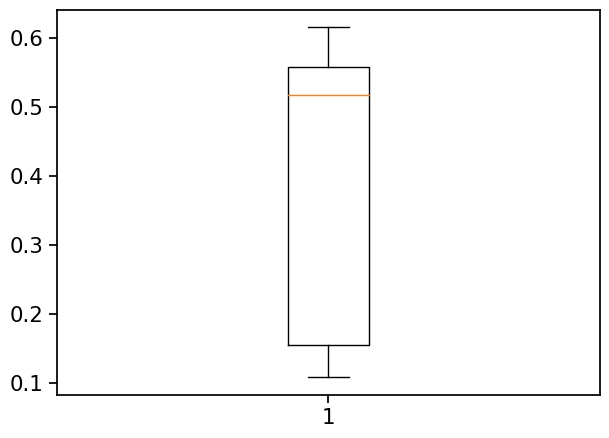

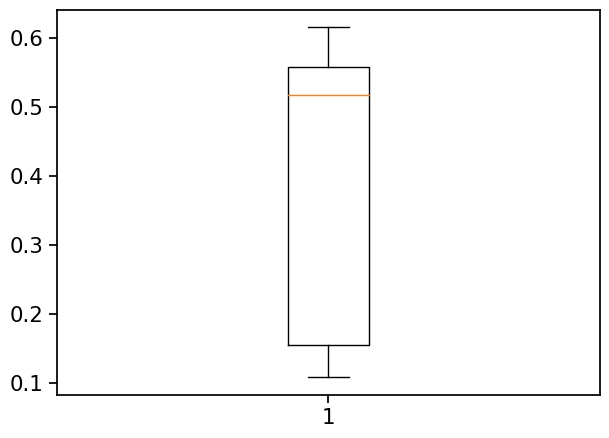

Pre-processing avGFP
Load avGFP encodings
Test enriched in higher values
train_index 29994
valid_index 8274
test_index 13447


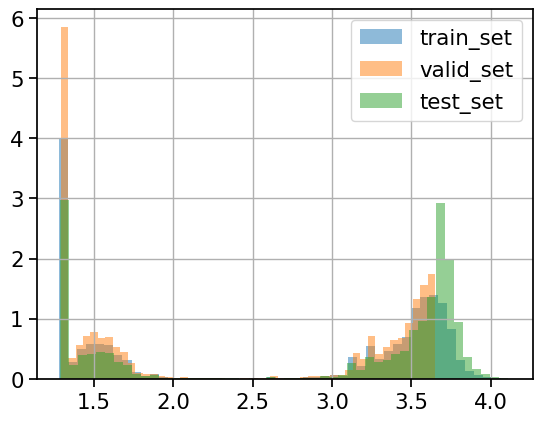

In [17]:
showmatrix=False
%run 01_preprocessing.ipynb

## Train
Train best architechture from Orthologous GFP Fitness Peaks 
using a EMS embedding instead of their one-hot encodding

In [6]:
# First split train, valid, test indexes (not very elegant, yes)
print("Split train, valid, test sets")

(predictors_train,
predictors_valid_test, 
target_train, 
target_valid_test) = train_test_split(df.index, 
                                     df.index, 
                                     test_size=0.4, 
                                     random_state=42)

(predictors_valid, 
predictors_test, 
target_valid,
target_test) = train_test_split(predictors_valid_test, 
                               target_valid_test, 
                               test_size=0.5, 
                               random_state=42)

train_index = sorted(predictors_train)
valid_index = sorted(predictors_valid)
test_index  = sorted(predictors_test)


Split train, valid, test sets


In [6]:
# load embeddings 
import pandas as pd
import keras
# Load the training data
predictors_train = pd.read_csv('predictors_train.csv')
predictors_train.index = train_index
target_train = pd.read_csv('target_train.csv')
target_train.index = train_index

# Load the validation data
predictors_valid = pd.read_csv('predictors_valid.csv')
predictors_valid.index = valid_index
target_valid = pd.read_csv('target_valid.csv')
target_valid.index = valid_index

# Load the test data
predictors_test = pd.read_csv('predictors_test.csv')
predictors_test.index = test_index
target_test = pd.read_csv('target_test.csv')
target_test.index = test_index



In [7]:
def make_model():
    inputs = Input(shape=(predictors_train.shape[1],))
    hidden1 = Dense(int(best_Hparams["neurons_in_1st_h_layer"]),activation="linear")(inputs)
    dropout1 = Dropout(dropout_rate,name="D1")(hidden1,training=True)
    hidden2 = Dense(int(best_Hparams["neurons_in_2nd_h_layer"]),activation="sigmoid")(dropout1)
    dropout2 = Dropout(dropout_rate,name="D2")(hidden2,training=True)
    predictions = Dense(1,activation="linear")(dropout2)
    
    optimizer = keras.optimizers.Adam()
    
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer=optimizer,
                  loss="mean_squared_error",
                  metrics=['mae'])
    return(model)

## train their best architecture wiht EMS encodding

In [8]:
dropout_rate = 0.1
optimizer = keras.optimizers.Adam()

def optimize_model(x_train, y_train, x_val, y_val, params):
    
    def fitted_model(x_train, y_train, x_val, y_val, params):
        
        inputs = Input(shape=(predictors_train.shape[1],))
        hidden1 = Dense(int(params["neurons_in_1st_h_layer"]),activation="linear",name="L1")(inputs)
        dropout1 = Dropout(dropout_rate,name="D1")(hidden1)
        hidden2 = Dense(int(params["neurons_in_2nd_h_layer"]),activation="sigmoid",name="L2")(dropout1)
        dropout2 = Dropout(dropout_rate,name="D2")(hidden2)
        predictions = Dense(1,activation="linear")(dropout2)        
        
        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer=optimizer,loss="mean_squared_error",metrics=['mae'])

        out = model.fit(x_train,y_train,
                        validation_data=[x_val,y_val],
                       epochs=20,
                       shuffle=True)

        return out, model

    scan_object = talos.Scan(x=x_train,
                             y=y_train,
                             x_val=x_val,
                             y_val=y_val,
                             model=fitted_model,
                             experiment_name="fit N-N-1",
                             params=params,
                             fraction_limit=0.1,
                             reduction_metric='val_loss',
                             minimize_loss=True,
                             print_params=True,
                             random_method="quantum")

    return scan_object

In [9]:
# create parameter dict
params = {}
params["neurons_in_1st_h_layer"] = [*range(1,11)]+[20,50,100,200]
params["neurons_in_2nd_h_layer"] = [*range(1,11)]+[20,50,100,200]

In [10]:
import talos
opt_file = modelsPath+gene_name+"_talos_optim.csv"

# try: 
#     optimisation_results = pd.read_csv(opt_file)
    
# except:
optimisation_results = optimize_model(x_train=predictors_train.values,
                                        y_train=target_train.values,
                                        x_val=predictors_valid.values,
                                        y_val=target_valid,
                                        params=params)

optimisation_results.data.to_csv(opt_file)
optimisation_results = pd.read_csv(opt_file)

  0%|          | 0/19 [00:00<?, ?it/s]

{'neurons_in_1st_h_layer': 20, 'neurons_in_2nd_h_layer': 100}
Epoch 1/20
444/444 [==============================] - 3s 4ms/step - loss: 1.5112 - mae: 1.0417 - val_loss: 0.9884 - val_mae: 0.9305
Epoch 2/20
444/444 [==============================] - 2s 4ms/step - loss: 1.0463 - mae: 0.9463 - val_loss: 0.9681 - val_mae: 0.9370
Epoch 3/20
444/444 [==============================] - 2s 4ms/step - loss: 1.0233 - mae: 0.9403 - val_loss: 0.9528 - val_mae: 0.9226
Epoch 4/20
444/444 [==============================] - 2s 4ms/step - loss: 0.9852 - mae: 0.9171 - val_loss: 0.9184 - val_mae: 0.8981
Epoch 5/20
444/444 [==============================] - 2s 4ms/step - loss: 0.9580 - mae: 0.8959 - val_loss: 1.0023 - val_mae: 0.9284
Epoch 6/20
444/444 [==============================] - 2s 4ms/step - loss: 0.9174 - mae: 0.8659 - val_loss: 0.8976 - val_mae: 0.8419
Epoch 7/20
444/444 [==============================] - 2s 4ms/step - loss: 0.9047 - mae: 0.8562 - val_loss: 0.8517 - val_mae: 0.8458
Epoch 8/20
444

  5%|▌         | 1/19 [00:38<11:32, 38.46s/it]

{'neurons_in_1st_h_layer': 2, 'neurons_in_2nd_h_layer': 8}
Epoch 1/20
444/444 [==============================] - 2s 5ms/step - loss: 1.4967 - mae: 1.0370 - val_loss: 0.9803 - val_mae: 0.9457
Epoch 2/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2641 - mae: 0.9856 - val_loss: 0.9800 - val_mae: 0.9468
Epoch 3/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2024 - mae: 0.9715 - val_loss: 0.9778 - val_mae: 0.9465
Epoch 4/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1607 - mae: 0.9628 - val_loss: 0.9731 - val_mae: 0.9429
Epoch 5/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1424 - mae: 0.9615 - val_loss: 0.9662 - val_mae: 0.9380
Epoch 6/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1168 - mae: 0.9516 - val_loss: 0.9605 - val_mae: 0.9334
Epoch 7/20
444/444 [==============================] - 2s 4ms/step - loss: 1.0919 - mae: 0.9463 - val_loss: 0.9530 - val_mae: 0.9274
Epoch 8/20
444/44

 11%|█         | 2/19 [01:16<10:47, 38.11s/it]

{'neurons_in_1st_h_layer': 8, 'neurons_in_2nd_h_layer': 5}
Epoch 1/20
444/444 [==============================] - 2s 4ms/step - loss: 1.3917 - mae: 1.0223 - val_loss: 0.9838 - val_mae: 0.9505
Epoch 2/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2552 - mae: 0.9859 - val_loss: 0.9825 - val_mae: 0.9492
Epoch 3/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2207 - mae: 0.9790 - val_loss: 0.9805 - val_mae: 0.9461
Epoch 4/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1920 - mae: 0.9722 - val_loss: 0.9814 - val_mae: 0.9477
Epoch 5/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1717 - mae: 0.9706 - val_loss: 0.9826 - val_mae: 0.9494
Epoch 6/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1656 - mae: 0.9723 - val_loss: 0.9874 - val_mae: 0.9536
Epoch 7/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1366 - mae: 0.9614 - val_loss: 0.9822 - val_mae: 0.9488
Epoch 8/20
444/44

 16%|█▌        | 3/19 [01:53<10:00, 37.54s/it]

{'neurons_in_1st_h_layer': 2, 'neurons_in_2nd_h_layer': 50}
Epoch 1/20
444/444 [==============================] - 2s 5ms/step - loss: 1.6281 - mae: 1.0578 - val_loss: 0.9812 - val_mae: 0.9390
Epoch 2/20
444/444 [==============================] - 2s 4ms/step - loss: 1.0820 - mae: 0.9538 - val_loss: 0.9883 - val_mae: 0.9543
Epoch 3/20
444/444 [==============================] - 2s 4ms/step - loss: 1.0629 - mae: 0.9534 - val_loss: 0.9850 - val_mae: 0.9520
Epoch 4/20
444/444 [==============================] - 2s 4ms/step - loss: 1.0450 - mae: 0.9494 - val_loss: 0.9807 - val_mae: 0.9479
Epoch 5/20
444/444 [==============================] - 2s 4ms/step - loss: 1.0363 - mae: 0.9488 - val_loss: 0.9807 - val_mae: 0.9483
Epoch 6/20
444/444 [==============================] - 2s 4ms/step - loss: 1.0337 - mae: 0.9485 - val_loss: 0.9777 - val_mae: 0.9453
Epoch 7/20
444/444 [==============================] - 2s 4ms/step - loss: 1.0255 - mae: 0.9473 - val_loss: 0.9771 - val_mae: 0.9353
Epoch 8/20
444/4

 21%|██        | 4/19 [02:32<09:30, 38.06s/it]

{'neurons_in_1st_h_layer': 6, 'neurons_in_2nd_h_layer': 1}
Epoch 1/20
444/444 [==============================] - 2s 5ms/step - loss: 8.9519 - mae: 2.8072 - val_loss: 6.6146 - val_mae: 2.3737
Epoch 2/20
444/444 [==============================] - 2s 4ms/step - loss: 5.4168 - mae: 2.1019 - val_loss: 4.3901 - val_mae: 1.8484
Epoch 3/20
444/444 [==============================] - 2s 4ms/step - loss: 3.6922 - mae: 1.6496 - val_loss: 3.0594 - val_mae: 1.4590
Epoch 4/20
444/444 [==============================] - 2s 4ms/step - loss: 2.6140 - mae: 1.3233 - val_loss: 2.2032 - val_mae: 1.1998
Epoch 5/20
444/444 [==============================] - 2s 4ms/step - loss: 1.9186 - mae: 1.1430 - val_loss: 1.6555 - val_mae: 1.0931
Epoch 6/20
444/444 [==============================] - 2s 4ms/step - loss: 1.4810 - mae: 1.0671 - val_loss: 1.3208 - val_mae: 1.0372
Epoch 7/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2211 - mae: 1.0197 - val_loss: 1.1309 - val_mae: 0.9994
Epoch 8/20
444/44

 26%|██▋       | 5/19 [03:11<09:00, 38.60s/it]

{'neurons_in_1st_h_layer': 4, 'neurons_in_2nd_h_layer': 7}
Epoch 1/20
444/444 [==============================] - 2s 5ms/step - loss: 1.4544 - mae: 1.0241 - val_loss: 0.9797 - val_mae: 0.9427
Epoch 2/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2358 - mae: 0.9783 - val_loss: 0.9796 - val_mae: 0.9429
Epoch 3/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2107 - mae: 0.9756 - val_loss: 0.9803 - val_mae: 0.9409
Epoch 4/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1812 - mae: 0.9690 - val_loss: 0.9805 - val_mae: 0.9462
Epoch 5/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1650 - mae: 0.9684 - val_loss: 0.9836 - val_mae: 0.9504
Epoch 6/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1407 - mae: 0.9635 - val_loss: 0.9815 - val_mae: 0.9479
Epoch 7/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1359 - mae: 0.9629 - val_loss: 0.9801 - val_mae: 0.9445
Epoch 8/20
444/44

 32%|███▏      | 6/19 [03:50<08:23, 38.77s/it]

{'neurons_in_1st_h_layer': 200, 'neurons_in_2nd_h_layer': 20}
Epoch 1/20
444/444 [==============================] - 3s 5ms/step - loss: 1.2073 - mae: 0.9775 - val_loss: 0.9952 - val_mae: 0.9585
Epoch 2/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1322 - mae: 0.9652 - val_loss: 0.9801 - val_mae: 0.9446
Epoch 3/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1069 - mae: 0.9572 - val_loss: 0.9805 - val_mae: 0.9460
Epoch 4/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1153 - mae: 0.9628 - val_loss: 0.9806 - val_mae: 0.9462
Epoch 5/20
444/444 [==============================] - 2s 4ms/step - loss: 1.0934 - mae: 0.9574 - val_loss: 0.9800 - val_mae: 0.9443
Epoch 6/20
444/444 [==============================] - 2s 4ms/step - loss: 1.0788 - mae: 0.9517 - val_loss: 0.9832 - val_mae: 0.9500
Epoch 7/20
444/444 [==============================] - 2s 4ms/step - loss: 1.0802 - mae: 0.9569 - val_loss: 0.9816 - val_mae: 0.9481
Epoch 8/20
444

 37%|███▋      | 7/19 [04:31<07:52, 39.41s/it]

{'neurons_in_1st_h_layer': 7, 'neurons_in_2nd_h_layer': 4}
Epoch 1/20
444/444 [==============================] - 2s 4ms/step - loss: 2.9432 - mae: 1.4281 - val_loss: 1.1352 - val_mae: 1.0004
Epoch 2/20
444/444 [==============================] - 2s 4ms/step - loss: 1.3493 - mae: 1.0230 - val_loss: 0.9938 - val_mae: 0.9577
Epoch 3/20
444/444 [==============================] - 2s 4ms/step - loss: 1.3025 - mae: 0.9962 - val_loss: 0.9867 - val_mae: 0.9530
Epoch 4/20
444/444 [==============================] - 2s 4ms/step - loss: 1.3042 - mae: 1.0005 - val_loss: 0.9863 - val_mae: 0.9527
Epoch 5/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2683 - mae: 0.9878 - val_loss: 0.9883 - val_mae: 0.9542
Epoch 6/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2574 - mae: 0.9903 - val_loss: 0.9856 - val_mae: 0.9522
Epoch 7/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2180 - mae: 0.9790 - val_loss: 0.9890 - val_mae: 0.9547
Epoch 8/20
444/44

 42%|████▏     | 8/19 [05:10<07:12, 39.31s/it]

{'neurons_in_1st_h_layer': 7, 'neurons_in_2nd_h_layer': 2}
Epoch 1/20
444/444 [==============================] - 2s 5ms/step - loss: 2.0353 - mae: 1.2101 - val_loss: 1.0141 - val_mae: 0.9669
Epoch 2/20
444/444 [==============================] - 2s 4ms/step - loss: 1.3707 - mae: 1.0149 - val_loss: 0.9891 - val_mae: 0.9547
Epoch 3/20
444/444 [==============================] - 2s 4ms/step - loss: 1.3413 - mae: 1.0063 - val_loss: 0.9875 - val_mae: 0.9536
Epoch 4/20
444/444 [==============================] - 2s 4ms/step - loss: 1.3201 - mae: 1.0050 - val_loss: 0.9877 - val_mae: 0.9538
Epoch 5/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2732 - mae: 0.9872 - val_loss: 0.9899 - val_mae: 0.9553
Epoch 6/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2459 - mae: 0.9854 - val_loss: 0.9854 - val_mae: 0.9520
Epoch 7/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2164 - mae: 0.9812 - val_loss: 0.9855 - val_mae: 0.9521
Epoch 8/20
444/44

 47%|████▋     | 9/19 [05:49<06:31, 39.20s/it]

{'neurons_in_1st_h_layer': 20, 'neurons_in_2nd_h_layer': 7}
Epoch 1/20
444/444 [==============================] - 2s 5ms/step - loss: 1.8541 - mae: 1.1517 - val_loss: 0.9877 - val_mae: 0.9538
Epoch 2/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2835 - mae: 0.9875 - val_loss: 0.9895 - val_mae: 0.9550
Epoch 3/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2694 - mae: 0.9846 - val_loss: 0.9871 - val_mae: 0.9534
Epoch 4/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2471 - mae: 0.9846 - val_loss: 0.9827 - val_mae: 0.9494
Epoch 5/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2235 - mae: 0.9803 - val_loss: 0.9844 - val_mae: 0.9511
Epoch 6/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1894 - mae: 0.9739 - val_loss: 0.9821 - val_mae: 0.9487
Epoch 7/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1676 - mae: 0.9682 - val_loss: 0.9832 - val_mae: 0.9500
Epoch 8/20
444/4

 53%|█████▎    | 10/19 [06:28<05:53, 39.26s/it]

{'neurons_in_1st_h_layer': 8, 'neurons_in_2nd_h_layer': 5}
Epoch 1/20
444/444 [==============================] - 2s 4ms/step - loss: 2.3138 - mae: 1.2784 - val_loss: 1.0421 - val_mae: 0.9765
Epoch 2/20
444/444 [==============================] - 2s 4ms/step - loss: 1.3519 - mae: 1.0151 - val_loss: 0.9914 - val_mae: 0.9562
Epoch 3/20
444/444 [==============================] - 2s 4ms/step - loss: 1.3200 - mae: 0.9992 - val_loss: 0.9875 - val_mae: 0.9536
Epoch 4/20
444/444 [==============================] - 2s 4ms/step - loss: 1.3004 - mae: 0.9957 - val_loss: 0.9889 - val_mae: 0.9546
Epoch 5/20
444/444 [==============================] - 2s 4ms/step - loss: 1.3009 - mae: 0.9975 - val_loss: 0.9861 - val_mae: 0.9526
Epoch 6/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2563 - mae: 0.9895 - val_loss: 0.9852 - val_mae: 0.9519
Epoch 7/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2049 - mae: 0.9746 - val_loss: 0.9831 - val_mae: 0.9498
Epoch 8/20
444/44

 58%|█████▊    | 11/19 [07:03<05:02, 37.82s/it]

{'neurons_in_1st_h_layer': 50, 'neurons_in_2nd_h_layer': 2}
Epoch 1/20
444/444 [==============================] - 2s 4ms/step - loss: 3.8574 - mae: 1.6348 - val_loss: 1.7783 - val_mae: 1.1128
Epoch 2/20
444/444 [==============================] - 2s 4ms/step - loss: 1.6793 - mae: 1.1351 - val_loss: 1.1206 - val_mae: 0.9971
Epoch 3/20
444/444 [==============================] - 2s 4ms/step - loss: 1.4520 - mae: 1.0718 - val_loss: 1.0131 - val_mae: 0.9665
Epoch 4/20
444/444 [==============================] - 2s 4ms/step - loss: 1.4008 - mae: 1.0475 - val_loss: 0.9962 - val_mae: 0.9590
Epoch 5/20
444/444 [==============================] - 2s 4ms/step - loss: 1.3656 - mae: 1.0364 - val_loss: 0.9906 - val_mae: 0.9558
Epoch 6/20
444/444 [==============================] - 2s 4ms/step - loss: 1.3201 - mae: 1.0245 - val_loss: 0.9890 - val_mae: 0.9547
Epoch 7/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2816 - mae: 1.0136 - val_loss: 0.9902 - val_mae: 0.9555
Epoch 8/20
444/4

 63%|██████▎   | 12/19 [07:38<04:19, 37.03s/it]

{'neurons_in_1st_h_layer': 8, 'neurons_in_2nd_h_layer': 3}
Epoch 1/20
444/444 [==============================] - 2s 5ms/step - loss: 3.5599 - mae: 1.5663 - val_loss: 1.5948 - val_mae: 1.0834
Epoch 2/20
444/444 [==============================] - 2s 4ms/step - loss: 1.6387 - mae: 1.1252 - val_loss: 1.0827 - val_mae: 0.9879
Epoch 3/20
444/444 [==============================] - 2s 4ms/step - loss: 1.4951 - mae: 1.0787 - val_loss: 1.0084 - val_mae: 0.9647
Epoch 4/20
444/444 [==============================] - 2s 4ms/step - loss: 1.4294 - mae: 1.0546 - val_loss: 0.9959 - val_mae: 0.9588
Epoch 5/20
444/444 [==============================] - 2s 4ms/step - loss: 1.3564 - mae: 1.0327 - val_loss: 0.9934 - val_mae: 0.9574
Epoch 6/20
444/444 [==============================] - 2s 4ms/step - loss: 1.3577 - mae: 1.0368 - val_loss: 0.9888 - val_mae: 0.9545
Epoch 7/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2699 - mae: 1.0100 - val_loss: 0.9862 - val_mae: 0.9526
Epoch 8/20
444/44

 68%|██████▊   | 13/19 [08:18<03:46, 37.82s/it]

{'neurons_in_1st_h_layer': 9, 'neurons_in_2nd_h_layer': 4}
Epoch 1/20
444/444 [==============================] - 3s 5ms/step - loss: 1.4841 - mae: 1.0500 - val_loss: 0.9823 - val_mae: 0.9489
Epoch 2/20
444/444 [==============================] - 2s 4ms/step - loss: 1.3155 - mae: 0.9965 - val_loss: 0.9891 - val_mae: 0.9548
Epoch 3/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2833 - mae: 0.9946 - val_loss: 0.9845 - val_mae: 0.9512
Epoch 4/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2441 - mae: 0.9846 - val_loss: 0.9870 - val_mae: 0.9532
Epoch 5/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2087 - mae: 0.9771 - val_loss: 0.9812 - val_mae: 0.9474
Epoch 6/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2002 - mae: 0.9802 - val_loss: 0.9853 - val_mae: 0.9519
Epoch 7/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1658 - mae: 0.9739 - val_loss: 0.9824 - val_mae: 0.9490
Epoch 8/20
444/44

 74%|███████▎  | 14/19 [08:56<03:09, 37.93s/it]

{'neurons_in_1st_h_layer': 2, 'neurons_in_2nd_h_layer': 9}
Epoch 1/20
444/444 [==============================] - 2s 5ms/step - loss: 1.4120 - mae: 1.0191 - val_loss: 0.9795 - val_mae: 0.9469
Epoch 2/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2266 - mae: 0.9796 - val_loss: 0.9776 - val_mae: 0.9458
Epoch 3/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2075 - mae: 0.9774 - val_loss: 0.9746 - val_mae: 0.9385
Epoch 4/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1737 - mae: 0.9680 - val_loss: 0.9747 - val_mae: 0.9439
Epoch 5/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1469 - mae: 0.9606 - val_loss: 0.9718 - val_mae: 0.9384
Epoch 6/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1317 - mae: 0.9568 - val_loss: 0.9697 - val_mae: 0.9395
Epoch 7/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1179 - mae: 0.9570 - val_loss: 0.9661 - val_mae: 0.9356
Epoch 8/20
444/44

 79%|███████▉  | 15/19 [09:33<02:30, 37.74s/it]

{'neurons_in_1st_h_layer': 50, 'neurons_in_2nd_h_layer': 3}
Epoch 1/20
444/444 [==============================] - 2s 4ms/step - loss: 2.1722 - mae: 1.2443 - val_loss: 1.0277 - val_mae: 0.9719
Epoch 2/20
444/444 [==============================] - 2s 4ms/step - loss: 1.3596 - mae: 1.0158 - val_loss: 0.9910 - val_mae: 0.9560
Epoch 3/20
444/444 [==============================] - 2s 4ms/step - loss: 1.3331 - mae: 1.0023 - val_loss: 0.9877 - val_mae: 0.9538
Epoch 4/20
444/444 [==============================] - 2s 4ms/step - loss: 1.3088 - mae: 0.9980 - val_loss: 0.9863 - val_mae: 0.9527
Epoch 5/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2860 - mae: 0.9947 - val_loss: 0.9865 - val_mae: 0.9529
Epoch 6/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2403 - mae: 0.9817 - val_loss: 0.9845 - val_mae: 0.9512
Epoch 7/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2177 - mae: 0.9770 - val_loss: 0.9843 - val_mae: 0.9511
Epoch 8/20
444/4

 84%|████████▍ | 16/19 [10:09<01:51, 37.26s/it]

{'neurons_in_1st_h_layer': 50, 'neurons_in_2nd_h_layer': 8}
Epoch 1/20
444/444 [==============================] - 2s 5ms/step - loss: 1.3923 - mae: 1.0246 - val_loss: 0.9851 - val_mae: 0.9518
Epoch 2/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2500 - mae: 0.9850 - val_loss: 0.9832 - val_mae: 0.9499
Epoch 3/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2307 - mae: 0.9853 - val_loss: 0.9839 - val_mae: 0.9506
Epoch 4/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1998 - mae: 0.9758 - val_loss: 0.9831 - val_mae: 0.9499
Epoch 5/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1694 - mae: 0.9683 - val_loss: 0.9838 - val_mae: 0.9505
Epoch 6/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1593 - mae: 0.9688 - val_loss: 0.9852 - val_mae: 0.9518
Epoch 7/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1359 - mae: 0.9641 - val_loss: 0.9842 - val_mae: 0.9510
Epoch 8/20
444/4

 89%|████████▉ | 17/19 [10:46<01:14, 37.12s/it]

{'neurons_in_1st_h_layer': 3, 'neurons_in_2nd_h_layer': 3}
Epoch 1/20
444/444 [==============================] - 2s 5ms/step - loss: 9.2118 - mae: 2.8465 - val_loss: 6.7096 - val_mae: 2.3937
Epoch 2/20
444/444 [==============================] - 2s 4ms/step - loss: 5.5372 - mae: 2.1290 - val_loss: 4.4658 - val_mae: 1.8686
Epoch 3/20
444/444 [==============================] - 2s 4ms/step - loss: 3.7776 - mae: 1.6742 - val_loss: 3.1167 - val_mae: 1.4770
Epoch 4/20
444/444 [==============================] - 2s 4ms/step - loss: 2.6756 - mae: 1.3416 - val_loss: 2.2446 - val_mae: 1.2110
Epoch 5/20
444/444 [==============================] - 2s 4ms/step - loss: 1.9607 - mae: 1.1511 - val_loss: 1.6835 - val_mae: 1.0976
Epoch 6/20
444/444 [==============================] - 2s 4ms/step - loss: 1.5062 - mae: 1.0707 - val_loss: 1.3371 - val_mae: 1.0401
Epoch 7/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2360 - mae: 1.0224 - val_loss: 1.1395 - val_mae: 1.0014
Epoch 8/20
444/44

 95%|█████████▍| 18/19 [11:25<00:37, 37.54s/it]

{'neurons_in_1st_h_layer': 10, 'neurons_in_2nd_h_layer': 7}
Epoch 1/20
444/444 [==============================] - 2s 4ms/step - loss: 2.7334 - mae: 1.3671 - val_loss: 1.0148 - val_mae: 0.9672
Epoch 2/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2631 - mae: 0.9936 - val_loss: 0.9846 - val_mae: 0.9513
Epoch 3/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2658 - mae: 0.9881 - val_loss: 0.9851 - val_mae: 0.9518
Epoch 4/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2340 - mae: 0.9822 - val_loss: 0.9834 - val_mae: 0.9502
Epoch 5/20
444/444 [==============================] - 2s 4ms/step - loss: 1.2170 - mae: 0.9800 - val_loss: 0.9834 - val_mae: 0.9502
Epoch 6/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1958 - mae: 0.9735 - val_loss: 0.9828 - val_mae: 0.9495
Epoch 7/20
444/444 [==============================] - 2s 4ms/step - loss: 1.1839 - mae: 0.9730 - val_loss: 0.9843 - val_mae: 0.9511
Epoch 8/20
444/4

100%|██████████| 19/19 [12:04<00:00, 38.16s/it]


In [11]:
best_Hparams = optimisation_results.loc[optimisation_results["val_loss"].argmin(),:]
best_Hparams

Unnamed: 0                              0
start                     03/16/24-152035
end                       03/16/24-152114
duration                        38.206412
round_epochs                           20
loss                             0.792749
mae                              0.770134
val_loss                         0.757101
val_mae                          0.773034
neurons_in_1st_h_layer                 20
neurons_in_2nd_h_layer                100
Name: 0, dtype: object

In [12]:
predictors_train

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
14,0.007224,0.014285,-0.062046,0.003763,-0.115702,-0.008050,-0.019103,-0.001733,0.017498,-0.074536,...,0.147863,0.018267,0.053354,0.099771,0.000780,0.152050,0.049986,-0.055720,-0.004169,-0.008387
15,0.004209,0.014968,-0.061871,0.004130,-0.118063,-0.004217,-0.018279,-0.000449,0.012326,-0.077071,...,0.148782,0.021057,0.058306,0.099937,0.000305,0.154293,0.052262,-0.051971,-0.008631,-0.003981
18,0.006192,0.014942,-0.059402,0.002586,-0.115056,-0.005162,-0.019999,0.003536,0.016962,-0.079628,...,0.148537,0.024389,0.056603,0.100819,-0.000044,0.152426,0.054557,-0.051190,-0.006109,-0.005549
20,0.006036,0.017855,-0.062558,0.000930,-0.115627,-0.007688,-0.018176,0.002416,0.012487,-0.080701,...,0.147988,0.025843,0.055707,0.099245,0.000832,0.155862,0.051461,-0.049904,-0.010682,-0.004821
22,0.002404,0.021203,-0.055836,-0.013095,-0.114605,-0.011020,-0.015449,0.004028,0.014075,-0.084360,...,0.144185,0.024647,0.049911,0.094082,-0.001707,0.156695,0.043172,-0.041994,-0.017746,-0.008590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92356,-0.003542,0.016121,-0.061353,-0.007897,-0.109717,-0.006265,-0.019895,0.005144,0.007688,-0.084148,...,0.143498,0.031751,0.061816,0.094074,0.001455,0.153270,0.048081,-0.037279,-0.024747,0.005786
92360,-0.003396,0.013782,-0.054930,0.002166,-0.117944,-0.001358,-0.023206,-0.007019,0.009040,-0.081818,...,0.138981,0.026489,0.058899,0.095681,0.000623,0.149220,0.057322,-0.045496,-0.022426,0.002118
92363,-0.001261,0.011546,-0.053345,-0.008106,-0.103279,0.000920,-0.028724,0.002078,-0.004784,-0.091583,...,0.140519,0.041341,0.057260,0.082870,-0.004074,0.155861,0.050700,-0.033265,-0.032474,0.007237
92384,-0.001480,0.015298,-0.054813,-0.002935,-0.104155,-0.004700,-0.016288,-0.001586,0.014611,-0.082452,...,0.141051,0.032205,0.057349,0.088761,0.000731,0.154208,0.047799,-0.044133,-0.023110,0.004505


_04_Models/cgreGFP_N1_N2_1_NN_re-optimized_EMSencoding.h5
Epoch 1/100
142/142 [==============================] - 1s 6ms/step - loss: 2.4838 - mae: 1.2421 - val_loss: 1.0748 - val_mae: 0.9570
Epoch 2/100
142/142 [==============================] - 1s 5ms/step - loss: 1.0741 - mae: 0.9557 - val_loss: 1.0507 - val_mae: 0.9462
Epoch 3/100
142/142 [==============================] - 1s 5ms/step - loss: 1.0460 - mae: 0.9475 - val_loss: 1.0337 - val_mae: 0.9436
Epoch 4/100
142/142 [==============================] - 1s 4ms/step - loss: 1.0392 - mae: 0.9481 - val_loss: 1.0346 - val_mae: 0.9472
Epoch 5/100
142/142 [==============================] - 1s 5ms/step - loss: 1.0213 - mae: 0.9425 - val_loss: 1.0279 - val_mae: 0.9461
Epoch 6/100
142/142 [==============================] - 1s 5ms/step - loss: 1.0106 - mae: 0.9380 - val_loss: 1.0142 - val_mae: 0.9343
Epoch 7/100
142/142 [==============================] - 1s 5ms/step - loss: 1.0136 - mae: 0.9397 - val_loss: 0.9996 - val_mae: 0.9294
Epoch 8/100

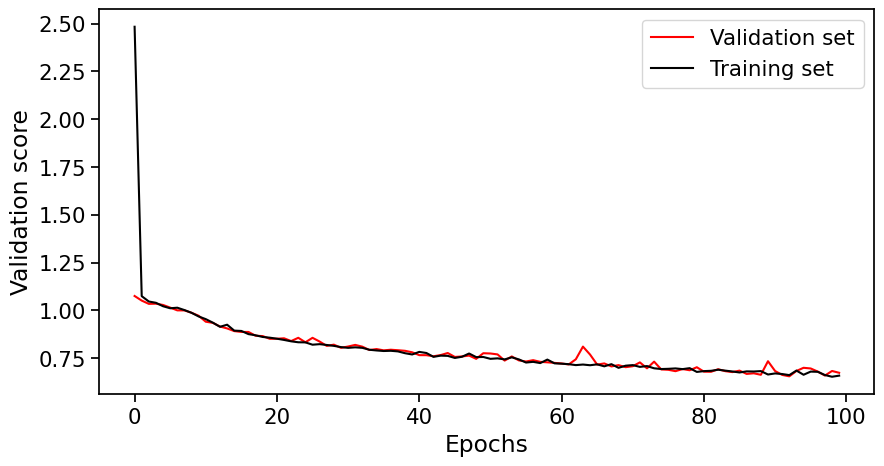

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1280)]            0         
                                                                 
 dense (Dense)               (None, 20)                25620     
                                                                 
 D1 (Dropout)                (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 100)               2100      
                                                                 
 D2 (Dropout)                (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 27,821
Trainable params: 27,821
Non-trainable p

In [13]:
# Train with best parameters (their original Hparameters + EMS encoding)

# model_file = modelsPath+gene_name+"_N1_N2_1_NN_optimized_EMSencoding.h5"

# Train with best parameters (re-optimized Hparameters + EMS encoding)

model_file = modelsPath+gene_name+"_N1_N2_1_NN_re-optimized_EMSencoding.h5"
print(model_file)

# try:
#     if recompute:raise
#     optimised_model = keras.models.load_model(model_file)
#     print("Found",model_file)
    
# except:
    
dropout_rate = 0.1

# create and fit model with best Hparams
optimised_model=make_model()    

early_stopping_monitor = EarlyStopping(patience=10)

checkpoint_filepath="./tmp_mdl_checkpoint"
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_loss',
                                            mode='min',
                                            save_best_only=True)

out = optimised_model.fit(predictors_train.values,target_train.values,
                            validation_data=(predictors_valid.values,target_valid.values),
                            epochs=100,
                            shuffle=True,
                            batch_size=100,
                            callbacks=[early_stopping_monitor,model_checkpoint_callback])

optimised_model.load_weights(checkpoint_filepath)

fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('w')

plt.plot(out.history['val_loss'], 'r')
plt.plot(out.history['loss'], 'k')

plt.xlabel('Epochs')
plt.ylabel('Validation score')

plt.legend(("Validation set","Training set"))

plt.show()

optimised_model.save(model_file)

optimised_model.summary()


In [ ]:
predictions_as_df

In [14]:
# takes a bit of time, as the model predicts 10 times each genotype

train_set_muts = sorted(list(flatten([ elt.split(":") for elt in df.loc[train_index,:][genotype_col].values.flatten()])))
train_set_muts_unique = sorted(list(set(train_set_muts)))
counts_in_training_set=Counter(train_set_muts)

#-------------------------------
predictions_=pd.DataFrame(np.concatenate([optimised_model.predict(predictors_valid.values) for i in range(10)],axis=1),
                          index=predictors_valid.index)

predictions_median=pd.DataFrame(np.median(predictions_,axis=1),
                                index=predictors_valid.index,
                                columns=["median"])

predictions_std=pd.DataFrame(predictions_.std(axis=1),
                             index=predictors_valid.index,
                             columns=["std"])

predictions_as_df = pd.concat([df.loc[valid_index,:][[genotype_col]],
                               predictions_median,
                               predictions_std],
                              axis=1)

# find for each validation genotype the mutation with the min number of occurences
predictions_as_df["min_nb_of_contexts"] = predictions_as_df[genotype_col].apply(lambda x:min([counts_in_training_set.get(elt,0) for elt in x.split(":")]))


148/148 [==============================] - 0s 2ms/step


In [15]:
plot_range=(1,5)
plot_clim=None

if gene_name=="amacGFP":
    plot_range=(2,5)
    plot_clim=(1,200)
elif gene_name=="avGFP":
    plot_range=(1.3,5)
    plot_clim=(1,1000)
elif gene_name=="cgreGFP":
    plot_range=(1.5,5)
    plot_clim=(1,300)
elif gene_name=="ppluGFP":
    plot_range=(2,5)
    plot_clim=(1,200)


r2 0.347


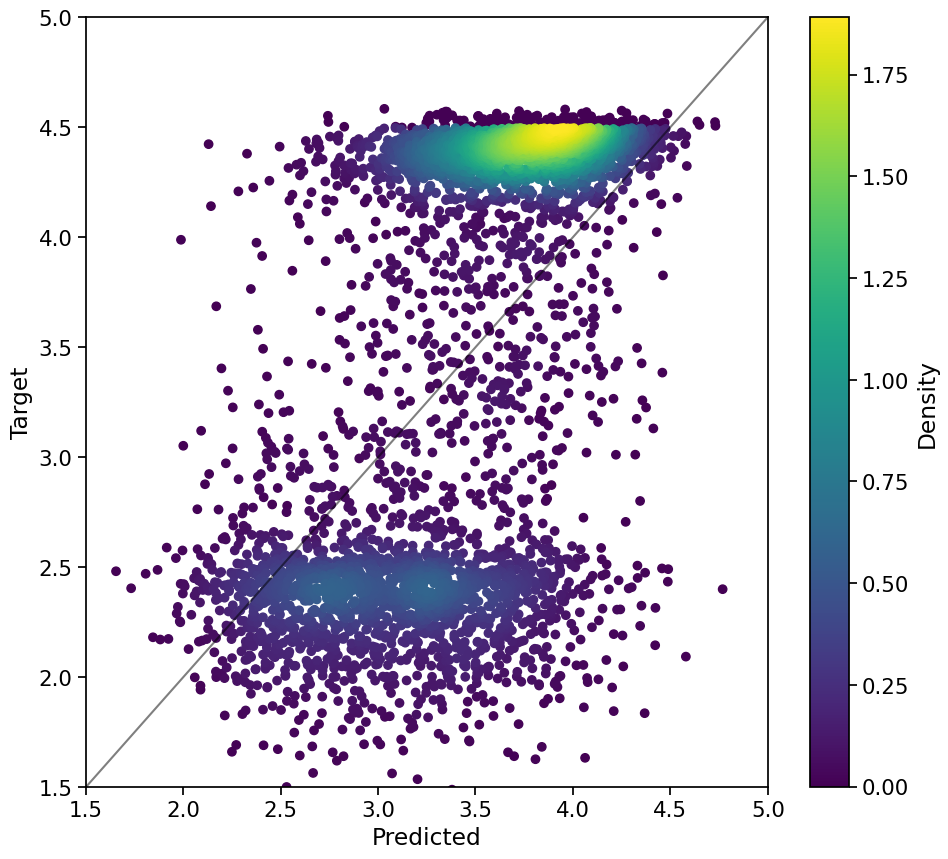

In [16]:

pred = predictions_median.values.flatten()
tar = target_valid.values.flatten()

r2_valid = r2_score(y_true=tar,y_pred=pred)
print("r2 %.3f" % r2_valid)

density_scatter(pred,tar, ax = None, sort = True, bins = 20)

plt.xlim(plot_range) 
plt.ylim(plot_range)  
plt.xlabel("Predicted")
plt.ylabel("Target")
plt.plot(plot_range,plot_range,color="k",alpha=0.5)

plt.show()

